## Multi-attribute decision making

Andrew Howes

July 2022

Multi-attribute decision making is the problem of choosing between multiple options each of which is described as a set of attribute/value pairs. People can be thought of as multi-attribute decision makers when for example they choose between different apartments, cars, or music channels. Payne, Bettman et al. conducted extensive studies of multi-attribute decision making in the 1980s and 1990s. 

For people, one part of the muti-attribute problem involves gathering information and more specifically, in what order to gather attribute/value pairs and when to stop. Typically, a person will not seek to gather information about all attribute/value pairs before stopping gathering information and making a decision. 

The process of information gathering is believed to be an active, sequential process with each decision as to what to do next informed by the information already gathered.

Typically, people gather information from computer displays using eye-movements and fixations. The pattern of eye-movements is known to be influenced by the design of the interface but also by the relative value of the attributes to determining the utility of the outcome.

The purpose of this notebook is to introduce a reinforcement learning model of how human's gather information in service of multi-attribute decisions. The notebook loosely follows the logic of Chen et al. (2017).

Rather than strategies being programmed into the model, instead a policy for how to move the eyes is learned using reinforcement learning. The learned policy is the optimal solution to a problem that is defined by the constraints imposed by the oculomotor and perceptual systems and by the reward function. 

<img src="image/example_decision_task.png" alt="An example decision task involving a choice between 3 apartments. Overlaid with an illustration of a typical pattern of eye-movements." width="500" height="400">

The decision problem is illustrated in the above figure. Here there is a choice between three apartments, each of which has three attributes. The attribute values are represented in a table. The red circles represent a sequence of eye-movements used to gather relevant information. While these eye-movements are fictional they represent a typical pattern in which the user has gathered all information about rents before looking at only the Location of Apartment B and only the sizes of Apartments A and B. Moreover, the pattern suggests a decision strategy known as 'decision-by-aspects'; here, attribute values are compared rather than each option being assessed independently.

### The cognitive architecture

The constraints of the model in this notebook are defined in a cognitive architecture -- an information processing model of the mind.

<img src="image/architecture.png" alt="Box diagram of a cognitive model." width="700" height="400">

A cognitive architecture represents a commitment to a theory of how information is processed in the human mind. The cognitive architecture in the figure consists of five modules (inside the dashed box) that interact with an external world.

Below, the modules have the following properties:

* **World** On each trial, a 
* **Perception** The location of target location stimuli are corrupted by Gaussian noise in human vision. The standard deviation of noise increases linearly with eccentricity from the fovea. 
* **Memory** Sequences of stimuli are optimally integrated.
* **Utility** Rewards are received for getting closer to the target.
* **Motor** Intended eye movements (oculomotor actions) are corrupted by signal dependent Gaussian noise to generate responses.
* **Control**  The Control module observes the memory and receives a reward. It learns a policy for making eye movements to the target that maximises the reward.

A python implementation of each module is described below.

## Import and configure

In [1]:
# This cell only for users of Google Colab.
# No need to run this if you are using Jupyter notebooks
# Mount Google drive and change directory into the project folder
# Only needs to be run once

#!pip install stable_baselines3

#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/CHI22CMT/CHI22_CogMod_Tutorial/03-Reinforcement-Learning/034_Gaze_based_Interaction'


In [2]:
# Load local modules
# gazetools is a module that contains functions for modeling gaze-based interaction.

from tools import *


In [3]:
# Create a folder for the output files

#output_dir = 'output/'

#if not os.path.exists(output_dir):
#    os.mkdir(output_dir)

In [4]:
fldr = create_new_folder('results')

.folder_number_for_results.pickle


## Modules

### World Module

The World generates a **stimulus** and the agent can **respond** with an eye-movement.

The **stimulus** is the currently foveated cell of a table of values that are organised according to the figure above with options on rows and attributes in columns. 


In [5]:
class MultiAttributeDecisionMaking():
    ''' There is a table of attribute values and a set of decision buttons by which an option can be chosen. 
        There is a fixation on one of the values or on a decision button.
        '''
    
    def __init__(self, theta, output_dir):
        self.theta=theta
        self.output_dir=output_dir
        
    def reset(self):
        ''' The state of the World consists of a table of attribute/value pairs.'''
        
        def get_display():
            ''' A display consists of options on rows and attributes in columns. 
                The last column is the option buttons, so do not assign values.
            '''
            n_cols = self.theta['n_attr']+1
            self.display_dims = (n_cols, self.theta['n_options'])
            self.display = np.zeros(self.display_dims)
            # generate a table of values.
            # would be better to first generate stds and map onto (-1,1) rather than clip.
            value_dims = (self.theta['n_attr'], self.theta['n_options'])
            values = np.random.normal(0, 1, value_dims)
            self.values = np.clip(values, -0.9, 1) # reserve -1 for a null value meaning that the cell has not yet been looked at.
            self.display[0:-1,] = values
            return np.array( self.display )
    
        # the initial fixation
        self.fixation = np.array([-1,-1])
        # the target location for this episode
        self.display = get_display()
        return self.display
    
    def get_background(self, eps):
        ''' Generate a list of dictionaries each of which describes an element in the World.
        '''
        bgrnd = []
        for x in range(0,self.values.shape[0]):
            for y in range(0,self.values.shape[1]):
                bgrnd.append( {'type':'value', 'value':round(self.values[x,y]*100), 'x':x, 'y':y, 'episode':eps} )
        bgrnd.append( {'type':'button', 'value':'Option A', 'x':3, 'y':0, 'episode':eps} )
        bgrnd.append( {'type':'button', 'value':'Option B', 'x':3, 'y':1, 'episode':eps} )
        bgrnd.append( {'type':'button', 'value':'Option C', 'x':3, 'y':2, 'episode':eps} )
        return bgrnd

    def step(self, response):
        ''' The response is a discrete x,y display coordinate. 
            If the fixation is on a value then return its value in the display[] array as the (partial) observation.
            If the fixation is a button then return all attr values -- this gives ground truth feedback to the agent.
        '''
        self.fixation = response
        s_values = np.zeros(self.display_dims)
        # if an option has been selected then done=True...
        if response[0]==self.theta['n_attr']:
            done = True
            # experience and perceive all attribute values of the selected option.
            s_values[:,response[1]] = self.display[:,response[1]] 
            stimulus = {'fixation': self.fixation, 'values':s_values }
        else:
            # just perceive the fixated item...
            done = False
            # only perceive the foviated value
            s_values[ response[0], response[1] ] = self.display[ response[0], response[1] ]
            stimulus = {'fixation': self.fixation, 'values':s_values }
        return stimulus, done

class World(MultiAttributeDecisionMaking):
    pass

theta = {'n_attr':3, 'n_options':3}
world = World(theta, fldr)
display = world.reset()
print( display )
stimulus, done = world.step([3,1])
print( stimulus )
print (done)

[[-0.51627866 -3.0033507   0.70051273]
 [-0.02074139  1.28139589 -1.37161614]
 [-0.23353773 -1.10631136 -1.45249904]
 [ 0.          0.          0.        ]]
{'fixation': [3, 1], 'values': array([[ 0.        , -3.0033507 ,  0.        ],
       [ 0.        ,  1.28139589,  0.        ],
       [ 0.        , -1.10631136,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])}
True


### Perception Module

In [6]:

class Vision():
    ''' Foveated vision but with out any peripheral vision.
    '''
    def __init__(self, theta):
        self.theta = theta
    
    def reset(self):
        pass
    
    def step(self, stimulus):
 
        percept = stimulus
        return stimulus

class Perception(Vision):
    pass


### Memory Module

In [7]:
class Memory():
    ''' Keep a memory of percepts and fixations. Compute an observation of memory. 
        The memory is spatially structured.
        self.valmem is the memory of perceived values.
        self.fixmem is the memory of perceived fixation locations.
        These are concatenated to form the observation.
        An alternative to fixmem is a memory of variances combined with a Kalman filter.
    '''
    
    def __init__(self, theta):
        self.theta = theta
        self.reset()
        
    def reset(self):
        self.memory_dims = (self.theta['n_attr']+1, self.theta['n_options'])
        self.valmem = np.full(self.memory_dims, -1, dtype=float)
        self.fixmem = np.zeros(self.memory_dims)
        observation = np.concatenate((self.valmem.flatten(), self.fixmem.flatten()))
        return observation
    
    def step(self, percept):
        self.valmem[tuple(percept['fixation'])] = percept['values'][tuple(percept['fixation'])]
        self.fixmem[tuple(percept['fixation'])] = 1
        observation = np.concatenate((self.valmem.flatten(), self.fixmem.flatten()))
        return observation

display = world.reset()
print(display)
mem = Memory(theta)
m = mem.reset()
print(m)
m = mem.step({'fixation': [1,1], 'values': display })
print(m)

[[-0.49360801  0.1914226  -0.20784184]
 [ 0.48980696 -0.24177364  0.38893511]
 [-0.69608156  2.1177223   1.0494112 ]
 [ 0.          0.          0.        ]]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[-1.         -1.         -1.         -1.         -0.24177364 -1.
 -1.         -1.         -1.         -1.         -1.         -1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.        ]


### Utility Module

In [8]:

class Utility():
    ''' Compute the reward given an observation.
        Until a choice is made by focusing on the last column the reward is just the step cost.
        Once a button in the last column has been foveated and a choice made then the reward is the weighted sum of the attribute values.
        Note that all attribute values for the chosen option are in the percept... representing post choice experience.
        (This may be corrupted by noise but is not in this version.)
    '''
    
    def __init__(self, theta):
        self.theta = theta
    
    def reset(self):
        pass
    
    def step(self, percept):
        fixation = percept['fixation']
        values = percept['values']
        if fixation[0]==self.theta['n_attr']:
            reward_values = values[0:3,fixation[1]]
            reward_values = reward_values * self.theta['weights']
            reward = reward_values.sum(axis=0)
        else:
            reward = -self.theta['step_cost']
        return reward

theta = {'n_attr':3, 'n_options':3, 'step_cost':1, 'weights':np.array([10,100,1000])}
utility = Utility(theta)
values = world.reset()
percept = {'fixation': [3,0], 'values': values}
print(percept)
utility.step(percept)

{'fixation': [3, 0], 'values': array([[ 0.49503142, -0.18910854, -0.29926618],
       [-0.17452262,  2.33538853, -0.3297507 ],
       [ 0.79798782, -0.42632954,  1.28618541],
       [ 0.        ,  0.        ,  0.        ]])}


785.4858754442105

### Motor Module

In [9]:

class Oculomotor():
    
    def __init__(self, theta):
        ''' The current fixation is part of the motor system state. '''
        self.theta = theta
        self.fixation = np.array([-1,-1])
    
    def reset(self):
        self.fixation = np.array([-1,-1])
    
    def step(self, action):
        self.fixation = action
        return action

class Motor(Oculomotor):
    pass


### Control Module

The control module uses RL to find an optimal policy.


In [10]:
class Control():
    
    def __init__(self, theta, env, output_dir):
        self.env = env
        self.theta = theta
        self.output_dir = output_dir
        self.policy_file = 'policy'
        
    def train(self, timesteps):
        ''' Train the control module to find the optimal policy for the Gym environment.
            Monitor() and PPO() are part of the stable_baselines3 package.
            PPO (Proximal Policy Optimisation) is a class of RL algorithm https://openai.com/blog/openai-baselines-ppo/
            '''
        self.env = Monitor(self.env, self.output_dir)
        self.policy = PPO('MlpPolicy', self.env, verbose=0, clip_range=0.15)
        self.policy.learn(total_timesteps=int(timesteps))
        self.policy.save(f'{self.output_dir}{self.policy_file}')
        print('Done training.')
       
    def load_policy(self):
        self.policy = PPO.load(f'{self.output_dir}/{self.policy_file}')
        return self.policy

    def run(self, n_episodes, filename):
        '''
        run the model for n_episodes and save its behaviour in a csv file.
        Note that 'env' is a term used by Gym to describe everything but the controller.
        '''
        max_episodes = 900000
        #if n_episodes > max_episodes:
        #    print(f'We ask that you limit training to a max of {max_episodes} on the School of Computer Science AWS account.')
        #    print(f'If you want to run more training episodes then please do so on a local computer.')
        #    return

        result = []
        background = []
        # repeat for n episodes
        eps = 0
        while eps < n_episodes:                
            done = False
            step = 0
            obs = self.env.reset()
            new_bgrnd = self.env.world.get_background(eps)
            background = background + new_bgrnd
            # record the initial state
            init_action = (-1,-1)
            info = self.env.get_info(init_action, obs, 0, False)
            info['episode'] = eps
            result.append(info)
            # repeat until the gaze is on the target.
            while not done:
                step+=1
                # get the next prediction action from the policy
                action, _ = self.policy.predict(obs,deterministic = True)
                obs, reward, done, info = self.env.step(action)
                info['episode'] = eps
                result.append( info )
            eps+=1
        #path = f'{self.output_dir}/{filename}'
        #df = pd.DataFrame(result)
        #df.to_csv(path,index=False)
        data_to_csv( result, self.output_dir, filename )
        data_to_csv( background, self.output_dir, 'display.csv')


## The Model

The model is our model of cognition and the world. It is the environment for the control module. It defines the information flow between the modules defined above. 

It is defined as a Gym environment. For further information see: https://gym.openai.com/. gym.Env is a class provided by this library. The environments step function receives the action the controller and returns an observation.


In [11]:
class CogEnv(gym.Env):
    ''' The CogEnv defines the environment for the controller.
    '''
    
    def __init__(self, output_dir, theta={}, max_steps=10):

        self.theta = theta
        
        self.motor = Motor(theta)
        self.world = World(theta, output_dir)
        self.perception = Perception(theta)
        self.utility = Utility(theta)
        self.memory = Memory(theta)
        # The CogEnv defines the environment for the controller and therefore a Control object is not defined here.
        
        # The action_space and observation_space are required by gym. These define the range of each variable.
        # Each action has an x,y coordinate.
        # Each obsevation is of the entire display.
        
        self.n_actions = (self.theta['n_attr']+1, self.theta['n_options'])
        self.action_space = spaces.Discrete(np.prod(self.n_actions))
    
        self.observation_space = default_box(24)
        
        # max_fixations per episode. Used to curtail exploration early in training.
        self.max_steps = max_steps
        
    def reset(self):
        
        self.motor.reset()
        self.world.reset()
        self.perception.reset()
        self.utility.reset()
        observation = self.memory.reset()

        self.n_step = 0

        return observation

    def step(self, action):
        action = to_xy_coord( action, self.n_actions )
        ''' Define the information flow between the modules. '''
        response = self.motor.step(action)
        stimulus, done = self.world.step(response)
        percept = self.perception.step(stimulus)
        observation = self.memory.step(percept)
        reward = self.utility.step(percept)
        
        self.n_step+=1
        # give up if been looking for too long
        if self.n_step > self.max_steps:
            done = True
            reward = -3
            
        info = self.get_info( action, observation, reward, done )
        
        return observation, reward, done, info

    def get_info(self, action, observation, reward, done ):
        return {'step': self.n_step,
                'fixation_x': action[0],
                'fixation_y': action[1],
                'observation': observation,
                'reward': reward,
                'done': done}

def to_xy_coord( n, dims ):
    mapping = tuple(np.ndindex(dims))
    return mapping[n]


## Parameters

Define the model parameters

In [12]:

theta = {'n_attr':3, 'n_options':3, 'step_cost':0.01, 'weights':np.array([1,2,3])}


## Test the model

Step through the untrained model to check for simple bugs. Output a DataFrame with a row for each step.
More comprehensive tests needed.

In [13]:
model = CogEnv( fldr, theta=theta, max_steps=10 )

In [14]:

def step_test():
    j=0
    result = []
    done = False
    model.reset()
    while not done:
        # make a step with a randomly sampled action
        obs, reward, done, info = model.step(model.action_space.sample())
        result.append(info)
        j+=1
    df = pd.DataFrame(result)
    return df, j

info, i = step_test()

info

,step,fixation_x,fixation_y,observation,reward,done
0,1,0,2,"[-1.0, -1.0, 0.3823863722251043, -1.0, -1.0, -...",-0.010000,False
1,2,1,0,"[-1.0, -1.0, 0.3823863722251043, -0.6234380626...",-0.010000,False
2,3,1,2,"[-1.0, -1.0, 0.3823863722251043, -0.6234380626...",-0.010000,False
3,4,2,2,"[-1.0, -1.0, 0.3823863722251043, -0.6234380626...",-0.010000,False
4,5,2,2,"[-1.0, -1.0, 0.3823863722251043, -0.6234380626...",-0.010000,False
5,6,0,0,"[-0.7994017625808375, -1.0, 0.3823863722251043...",-0.010000,False
6,7,1,1,"[-0.7994017625808375, -1.0, 0.3823863722251043...",-0.010000,False
7,8,2,2,"[-0.7994017625808375, -1.0, 0.3823863722251043...",-0.010000,False
8,9,3,0,"[-0.7994017625808375, -1.0, 0.3823863722251043...",-1.576807,True


Calculate the average number of steps taken by the untrained model.

In [15]:
def mean_steps_taken():
    rs = []
    for k in range(0,10):
        info, i = step_test()
        rs.append(i)
    return sum(rs) / len(rs)

model.max_steps = 1000

r = mean_steps_taken()
        
print(r)

3.4


## Train the control module

We can train the control module to generate a policy.

By plotting the learning curve we can see whether the performance improves with training and whether the model approaches an optimum performance. We are interested in approximately optimal performance, so if the training curve is not approaching asymptote then we need to train with more timesteps or revise the model.

We can see that at first the model uses hundreds of fixations to find the target, this is because it has not yet learned to move the gaze in a way that is informed by the observation. As it learns to do this, it takes fewer steps to gaze at the target and its performance improves.

If our problem definition is correct then the model will get more 'human-like' the more that it is trained. In other words, training makes it a better model of interaction.

If we assume that people are computationally rational then the optimal solution to the gaze problem (as defined above) predicts human behavior.

In [16]:
model.max_steps = 12

control = Control(theta, model, fldr)

timesteps = 500000

control.train(timesteps)

Done training.


In [17]:

def save_model(model,results_folder):
    with open(f'{results_folder}/model.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_model(model, fldr)

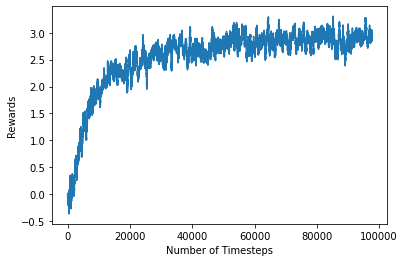

In [18]:
plot_learning_curve(fldr,800)


You should see a 'learning curve' in which as the model is trained with more 'timesteps' its performance improves. With more timesteps the rewards of each episode increase.

### Run the model
Run the trained model and save a trace of each episode to csv file.

In [19]:
control.run( 1000, 'behaviour_trace.csv' )

### Excercise

Retrain the control module but with timesteps=300000. Inspect the learning curve and note that there is now a clear asymptote in performance which approaches 0 loss.

Rerun the model to generate a new behaviour_trace.csv

## Next

Congratulations, you have now completed a Python notebook that introduces you to how to model cognition with RL. 

## References
Chen, X., Starke, S. D., Baber, C., & Howes, A. (2017, May). A cognitive model of how people make decisions through interaction with visual displays. In Proceedings of the 2017 CHI conference on human factors in computing systems (pp. 1205-1216).